In [1]:
import pandas

# TODO: extract columns from passenger id (group size) and cabin (deck, num, deck+num, side)
# TODO: show plots for Age, RoomService, FoodCourt, ShoppingMall, Spa, VRCeck

df = pandas.read_csv('data/train.csv')
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


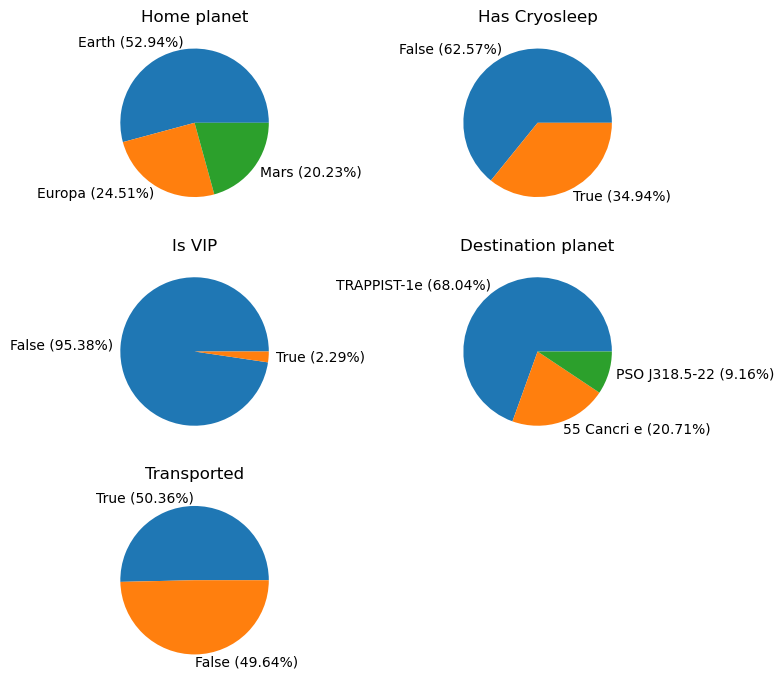

In [50]:
import matplotlib.pyplot as plt

def show_pie_chart_for_column(df, column, ax=None, title=None, with_percent=True):
    labels, values = [], []
    for label, val in df[column].value_counts().items():
        if isinstance(label, bool):
            label = str(label)
        if with_percent:
            percent = (val / len(df[column])) * 100.0
            label += f' ({percent:.2f}%)'
        labels.append(label)
        values.append(val)

    if not ax:
        fig, ax = plt.subplots()
    if title:
        ax.set_title(title)
    ax.pie(values, labels=labels)

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(7, 7))
fig.tight_layout(pad=1.0)

show_pie_chart_for_column(df, 'HomePlanet', ax=axs[0, 0], title='Home planet')
show_pie_chart_for_column(df, 'CryoSleep', ax=axs[0, 1], title='Has Cryosleep')
show_pie_chart_for_column(df, 'VIP', ax=axs[1, 0], title='Is VIP')
show_pie_chart_for_column(df, 'Destination', ax=axs[1, 1], title='Destination planet')
show_pie_chart_for_column(df, 'Transported', ax=axs[2, 0], title='Transported')
axs[2, 1].axis('off')

plt.show()